# Import Packages and create/verify dataframe.

In [1]:
#import necessary packages
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [2]:
#Create the dataframe
file = '../data/impute_ready.xlsx'
df = pd.read_excel (file,index_col=0)
print('file uploaded')

file uploaded


In [3]:
#print first five entries in DF to verify
df.head()

,ccode,year,country,region,con_ev_1,con_ev_2,con_ev_3,total_ev,con_in_1,con_in_2,...,rule_law,con1_next,con2_next,con3_next,con5_next,con10_next,con1_1_next,con1_2_next,con1_3_next,con_last3
index,,,,,,,,,,,,,,,,,,,,,
ABW1989,ABW,1989,Aruba,Latin America & Caribbean,0,0,0,0,0,0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
ABW1990,ABW,1990,Aruba,Latin America & Caribbean,0,0,0,0,0,0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
ABW1991,ABW,1991,Aruba,Latin America & Caribbean,0,0,0,0,0,0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABW1992,ABW,1992,Aruba,Latin America & Caribbean,0,0,0,0,0,0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABW1993,ABW,1993,Aruba,Latin America & Caribbean,0,0,0,0,0,0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#verify object type and null count
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6363 entries, ABW1989 to ZWE2018
Data columns (total 98 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ccode         6363 non-null   object 
 1   year          6363 non-null   int64  
 2   country       6363 non-null   object 
 3   region        6363 non-null   object 
 4   con_ev_1      6363 non-null   int64  
 5   con_ev_2      6363 non-null   int64  
 6   con_ev_3      6363 non-null   int64  
 7   total_ev      6363 non-null   int64  
 8   con_in_1      6363 non-null   int64  
 9   con_in_2      6363 non-null   int64  
 10  con_in_3      6363 non-null   int64  
 11  con_in        6363 non-null   int64  
 12  net_gs        4825 non-null   float64
 13  imp_gs        5277 non-null   float64
 14  gdp_cap       5809 non-null   float64
 15  gdp_cap_gr    5769 non-null   float64
 16  exp_gs        5277 non-null   float64
 17  inf           4885 non-null   float64
 18  out_sch_a     2006 non-n

# Imputation Process

## The chart below demonstrates the general flow chart for this imputation process. 

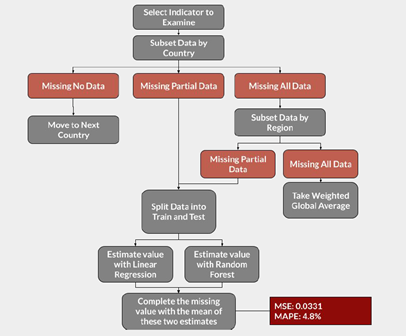

## First I establish lists of countries, regions, and quantitative columns to iterate through.

In [5]:
#create list containing all country abbreviations
countries = df.ccode.unique()

#create list containing all regions
regions =df.region.unique()

#create a list of all predictor variable columns
columns=list(df)

#This removes the four qualitative columns
unwanted = range(4) 
for ele in sorted(unwanted, reverse = True):
    del columns[ele] 

#Prints the number of countries, names and number of regions, and names of columns for verification
print(len(regions))
print()
print(regions)
print()
print(len(countries))
print()
print(columns)

7

['Latin America & Caribbean' 'South Asia' 'Sub-Saharan Africa'
 'Europe & Central Asia' 'Middle East & North Africa'
 'East Asia & Pacific' 'North America']

216

['con_ev_1', 'con_ev_2', 'con_ev_3', 'total_ev', 'con_in_1', 'con_in_2', 'con_in_3', 'con_in', 'net_gs', 'imp_gs', 'gdp_cap', 'gdp_cap_gr', 'exp_gs', 'inf', 'out_sch_a', 'out_sch_af', 'out_sch_am', 'out_sch_c', 'out_sch_cf', 'out_sch_cm', 'hs_grad_f', 'hs_grad_m', 'hs_grad', 'gov_ed', 'lit_r_f', 'lit_r_m', 'lit_r', 'acc_tech', 'acc_ele', 'acc_ele_r', 'acc_ele_u', 'ag_pct', 'wtr_wth', 'arable_pct', 'forest_pct', 'low_land_pct', 'wtr_str', 'min_rent', 'nat_gas_rent', 'oil_rent', 'pop_den', 'pop_den_low', 'pop_slum', 'pop_rural', 'pop_urb', 'death_nonc', 'death_c', 'sev_wast', 'stunt', 'under_n', 'under_w', 'pop_grow', 'price_diesel', 'price_gas', 'phone_fixed', 'pop_internet', 'phone_cell', 'mig_net', 'unemp', 'unemp_m', 'vul_emp_m', 'lf_rt_f', 'lf_rt_m', 'lf_rt_tot', 'pop_tot', 'gini', 'pov_hc', 'mil_exp', 'idp_conflict', '

## Initializing the linear regression and decision tree models I use to impute values.

In [6]:
#initialize linear and decision tree regressions for calling later
reg=LinearRegression()
dreg = DecisionTreeRegressor()

## This section calculates the weighted global average for each column. 

### I use 60% to reflect the groups previous assumption that missing values are likely negatively correlated with level of development.
### The weighted global mean is only used in a few variables for North America. None of these variables are used in the alternative specification so this assumption has no resulting impact on final findings.

In [7]:
#calculate the global average value and weights it to 60% based on the assumption that missing data is correlated with the level of country development.
for column in columns:
    df[column+'_global_qd']= df[[column]].mean(axis=1)*0.6
    print(column+' complete')

con_ev_1 complete
con_ev_2 complete
con_ev_3 complete
total_ev complete
con_in_1 complete
con_in_2 complete
con_in_3 complete
con_in complete
net_gs complete
imp_gs complete
gdp_cap complete
gdp_cap_gr complete
exp_gs complete
inf complete
out_sch_a complete
out_sch_af complete
out_sch_am complete
out_sch_c complete
out_sch_cf complete
out_sch_cm complete
hs_grad_f complete
hs_grad_m complete
hs_grad complete
gov_ed complete
lit_r_f complete
lit_r_m complete
lit_r complete
acc_tech complete
acc_ele complete
acc_ele_r complete
acc_ele_u complete
ag_pct complete
wtr_wth complete
arable_pct complete
forest_pct complete
low_land_pct complete
wtr_str complete
min_rent complete
nat_gas_rent complete
oil_rent complete
pop_den complete
pop_den_low complete
pop_slum complete
pop_rural complete
pop_urb complete
death_nonc complete
death_c complete
sev_wast complete
stunt complete
under_n complete
under_w complete
pop_grow complete
price_diesel complete
price_gas complete
phone_fixed complete
pop

## This section predicts yearly values for each variable at the regional level

In [8]:
#impute the predicted values at the region level
for region in regions:
    df_sub=df[df.region == region]
    print('working on '+region)
    for column in columns:
        df_col=df_sub.loc[:,{'region','year',column}]
        count_na=sum(pd.isnull(df_col[column]))
        count_value=sum(pd.notnull(df_col[column]))
        if count_value>0:
            df_reg=df_col.dropna()
            reg.fit(df_reg[['year']],df_reg[[column]])
            r = reg.predict(df[['year']])
            dreg.fit(df_reg[['year']],df_reg[[column]])
            d = dreg.predict(df[['year']])
            df['rlr_qd'] = r
            df['rdt_qd'] = d
            df[column+'_rpred_qd'] = df[['rdt_qd','rlr_qd']].mean(axis=1)

working on Latin America & Caribbean
working on South Asia
working on Sub-Saharan Africa
working on Europe & Central Asia
working on Middle East & North Africa
working on East Asia & Pacific
working on North America


## This section predicts yearly values for each variable at the country level.

### It also subsititues the imputed country, region, or global values for missing values in the dataframe.

In [9]:
#impute the values at the country level
for country in tqdm(countries):
    df_sub=df[df.ccode == country]
    #print('working on '+country)
    for column in columns:
        df_col=df_sub.loc[:,{'ccode','year',column}]
        count_na=sum(pd.isnull(df_col[column]))
        count_value=sum(pd.notnull(df_col[column]))
        
        #If some values at the country level are available, impute based on those values.
        if count_value>0:
            df_reg=df_col.dropna()
            reg.fit(df_reg[['year']],df_reg[[column]])
            r = reg.predict(df[['year']])
            dreg.fit(df_reg[['year']],df_reg[[column]])
            d = dreg.predict(df[['year']])
            df['lr_qd'] = r
            df['dt_qd'] = d
            df['pred_qd'] = df[['dt_qd','lr_qd']].mean(axis=1)
            df[[column]]=df.apply(lambda row: row['pred_qd'] if np.isnan(row[column]) else row[column], axis=1)
        
        
        else:
            #If no values are available at the country level we take the regional imputed values.
            if sum(pd.notnull(df[column+'_rpred_qd']))>0:
                df[[column]]=df.apply(lambda row: row[column+'_rpred_qd'] if np.isnan(row[column]) else row[column], axis=1)
            
            #Finally, if regional values are not available, then we take the scaled global mean
            else:
                df[[column]]=df.apply(lambda row: row[column+'_global_qd'] if np.isnan(row[column]) else row[column], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [1:37:15<00:00, 27.02s/it]


In [10]:
#remove all columns created for calculations. To do so, I ended the name all columns eventually to be removed with "qd"
df.columns.str.endswith('qd')
df=df.loc[:,~df.columns.str.endswith('qd')]
print('extra columns dropped')

extra columns dropped


# Calculates the summary stats for the imputed data. 
### Three variables result in measurements that do not make sense (the minimum is a negative number when no negative value is possible)... Underweight, Cell Phone Access, Internet Access. 
### None of these variables are used in either the base nore alternative specifications.

In [11]:
sum_stats_post = df.describe()

target = '../data/sum_stats_post.xlsx'
sum_stats_post.to_excel(target)
print('saved to '+target )

saved to ../data/sum_stats_post.xlsx


In [12]:
#save to excel file
target = '../data/imputed_data.xlsx'
df.to_excel(target)
print('saved to '+target )

saved to ../data/imputed_data.xlsx
